# Data Loading and Exploration

## Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import warnings
import os
import sys
import contextlib

In [14]:
data = pd.read_csv('data/obesity.csv')
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [15]:
data.dtypes

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [16]:
# Identify numerical and categorical columns
num_features = data.select_dtypes(include=['int64', 'float64']).columns
cat_features = data.select_dtypes(exclude=['int64', 'float64']).columns

In [17]:
data[cat_features].nunique()

Gender                            2
family_history_with_overweight    2
FAVC                              2
CAEC                              4
SMOKE                             2
SCC                               2
CALC                              4
MTRANS                            5
NObeyesdad                        7
dtype: int64

Seems to be an ordering to NObeyesdad and CAEC/CALC

In [18]:
print(data['NObeyesdad'].value_counts())
print(data['CAEC'].value_counts())
print(data['CALC'].value_counts())
print(data['MTRANS'].value_counts())

NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          286
Insufficient_Weight    272
Name: count, dtype: int64
CAEC
Sometimes     1765
Frequently     242
Always          53
no              51
Name: count, dtype: int64
CALC
Sometimes     1401
no             639
Frequently      70
Always           1
Name: count, dtype: int64
MTRANS
Public_Transportation    1578
Automobile                457
Walking                    56
Motorbike                  11
Bike                        7
Name: count, dtype: int64


After looking at the metadata, this is confirmed so we can move forward with encoding.

In [19]:
data_clean = data.copy()
data_clean['NObeyesdad'] = data_clean['NObeyesdad'].map({'Insufficient_Weight': -1, 'Normal_Weight': 0, 'Overweight_Level_I': 1, 'Overweight_Level_II': 2, 'Obesity_Type_I': 3, 'Obesity_Type_II': 4, 'Obesity_Type_III': 5})
data_clean['CAEC'] = data_clean['CAEC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean['CALC'] = data_clean['CALC'].map({'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
data_clean.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,1,no,2.0,no,0.0,1.0,0,Public_Transportation,0.0
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,1,yes,3.0,yes,3.0,0.0,1,Public_Transportation,0.0
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,1,no,2.0,no,2.0,1.0,2,Public_Transportation,0.0
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,1,no,2.0,no,2.0,0.0,2,Walking,1.0
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,1,no,2.0,no,0.0,0.0,1,Public_Transportation,2.0


In [20]:
data_clean = pd.get_dummies(data_clean, drop_first=True, dtype=int)
data_clean.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight_yes,FAVC_yes,SMOKE_yes,SCC_yes,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,21.0,1.62,64.0,2.0,3.0,1,2.0,0.0,1.0,0,0.0,0,1,0,0,0,0,0,1,0
1,21.0,1.52,56.0,3.0,3.0,1,3.0,3.0,0.0,1,0.0,0,1,0,1,1,0,0,1,0
2,23.0,1.80,77.0,2.0,3.0,1,2.0,2.0,1.0,2,0.0,1,1,0,0,0,0,0,1,0
3,27.0,1.80,87.0,3.0,3.0,1,2.0,2.0,0.0,2,1.0,1,0,0,0,0,0,0,0,1
4,22.0,1.78,89.8,2.0,1.0,1,2.0,0.0,0.0,1,2.0,1,0,0,0,0,0,0,1,0


In [21]:
# rename columns to get rid of _yes (it's obvious)
data_clean.columns = data_clean.columns.str.replace('_yes', '')
data_clean.describe()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
count,2111.000000,2111.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2110.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.567110,2.469702,2.685479,1.140692,2.030749,1.010777,0.657866,0.731407,2.113270,0.505921,0.817148,0.883941,0.020843,0.045476,0.003316,0.005211,0.747513,0.026528
std,6.345968,0.093305,26.237871,2.380357,0.778193,0.468543,1.211104,0.850509,0.608927,0.515498,1.984999,0.500083,0.386637,0.320371,0.142893,0.208395,0.057502,0.072015,0.434542,0.160737
min,14.000000,1.450000,2.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658689,1.000000,1.584812,0.127654,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.777890,1.700499,83.000000,2.387426,3.000000,1.000000,2.000000,1.000000,0.625350,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,26.000000,1.768464,107.430682,3.000000,3.000000,1.000000,2.479558,1.666821,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,61.000000,1.980000,173.000000,109.000000,4.000000,3.000000,50.000000,3.000000,2.000000,3.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Appears to be only one missing value and so it will be dropped

In [22]:
data_clean[data_clean['NCP'].isna()]

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
115,17.0,1.75,57.0,3.0,NaN,2,2.0,NaN,1.0,0,0.0,0,0,1,0,0,0,0,0,0


In [23]:
data_clean.dropna(inplace=True)
data_clean.corr()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
Age,1.000000,-0.025825,0.202043,0.022692,-0.043587,-0.082963,-0.029812,-0.145711,-0.297300,0.043964,0.282197,0.048280,0.205471,0.064279,0.091895,-0.116548,0.003599,0.020228,-0.554256,-0.063251
Height,-0.025825,1.000000,0.464112,-0.029364,0.243679,-0.049362,0.097600,0.295124,0.051623,0.130246,0.133739,0.619223,0.247526,0.178360,0.055517,-0.133749,0.029004,-0.010466,-0.089756,0.036969
Weight,0.202043,0.464112,1.000000,0.018209,0.109249,-0.287784,0.096745,-0.051164,-0.071655,0.205547,0.912706,0.162047,0.497771,0.272001,0.025690,-0.201668,-0.021724,-0.037260,0.059346,-0.100694
FCVC,0.022692,-0.029364,0.018209,1.000000,0.042835,0.051134,0.003925,-0.000117,-0.045866,-0.016387,0.017727,-0.082955,0.018883,0.001589,0.000108,0.011474,-0.007921,-0.003225,0.025340,-0.000374
NCP,-0.043587,0.243679,0.109249,0.042835,1.000000,0.097595,0.036495,0.129788,0.036441,0.071963,0.027115,0.067642,0.071771,-0.007140,0.007868,-0.015542,0.023336,0.003903,-0.057084,0.006566
CAEC,-0.082963,-0.049362,-0.287784,0.051134,0.097595,1.000000,-0.079070,0.031177,0.047981,-0.046295,-0.329022,-0.090641,-0.170828,-0.150464,0.055434,0.109430,0.017914,0.076699,-0.003438,0.082760
CH2O,-0.029812,0.097600,0.096745,0.003925,0.036495,-0.079070,1.000000,0.128607,0.047467,0.019600,0.066265,0.073217,0.083562,-0.046901,-0.018936,-0.000037,0.012144,-0.001840,-0.013400,0.117961
FAF,-0.145711,0.295124,-0.051164,-0.000117,0.129788,0.031177,0.128607,1.000000,0.058912,-0.087671,-0.200681,0.189196,-0.056502,-0.107832,0.011137,0.074123,0.067119,-0.016397,-0.048445,0.108870
TUE,-0.297300,0.051623,-0.071655,-0.045866,0.036441,0.047981,0.047467,0.058912,1.000000,-0.045260,-0.108350,0.018060,0.021765,0.068534,0.017584,-0.010986,-0.021747,-0.067444,0.143813,0.073391
CALC,0.043964,0.130246,0.205547,-0.016387,0.071963,-0.046295,0.019600,-0.087671,-0.045260,1.000000,0.151462,-0.008549,-0.035895,0.089728,0.082455,0.003372,-0.017939,-0.026159,0.024365,-0.017003


In [24]:
corr_matrix = data_clean.corr()

# Create a condensed correlation matrix
condensed_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack().reset_index()
condensed_corr.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Add a temporary column for sorting by absolute values
condensed_corr['AbsCorrelation'] = condensed_corr['Correlation'].abs()
condensed_corr_sorted = condensed_corr.sort_values('AbsCorrelation', ascending=False)
condensed_corr_sorted = condensed_corr_sorted.drop(columns=['AbsCorrelation'])

print(condensed_corr_sorted)

      Feature 1                       Feature 2  Correlation
44       Weight                      NObeyesdad     0.912706
28       Height                     Gender_Male     0.619223
17          Age    MTRANS_Public_Transportation    -0.554256
146  NObeyesdad  family_history_with_overweight     0.505153
46       Weight  family_history_with_overweight     0.497771
..          ...                             ...          ...
63         FCVC                            FAVC     0.001589
69         FCVC                  MTRANS_Walking    -0.000374
57         FCVC                             FAF    -0.000117
64         FCVC                           SMOKE     0.000108
107        CH2O                             SCC    -0.000037

[190 rows x 3 columns]


In [25]:
def plot_data(x, y, data):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, data=data)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.show()

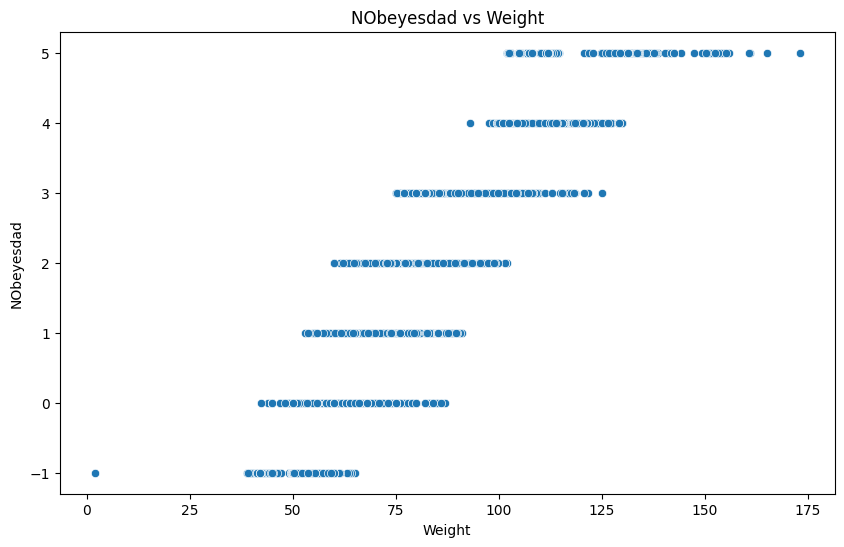

In [26]:
plot_data('Weight', 'NObeyesdad', data_clean)

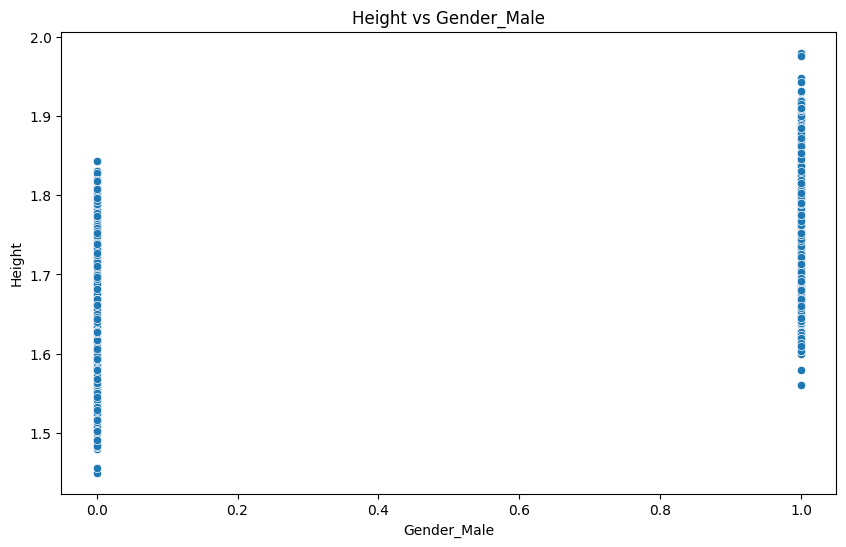

In [27]:
plot_data('Gender_Male', 'Height', data_clean)

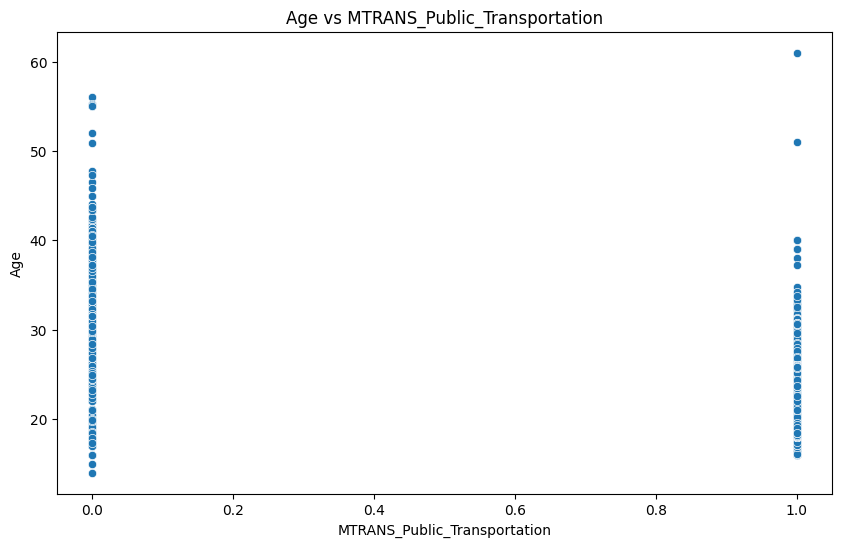

In [28]:
plot_data('MTRANS_Public_Transportation', 'Age', data_clean)

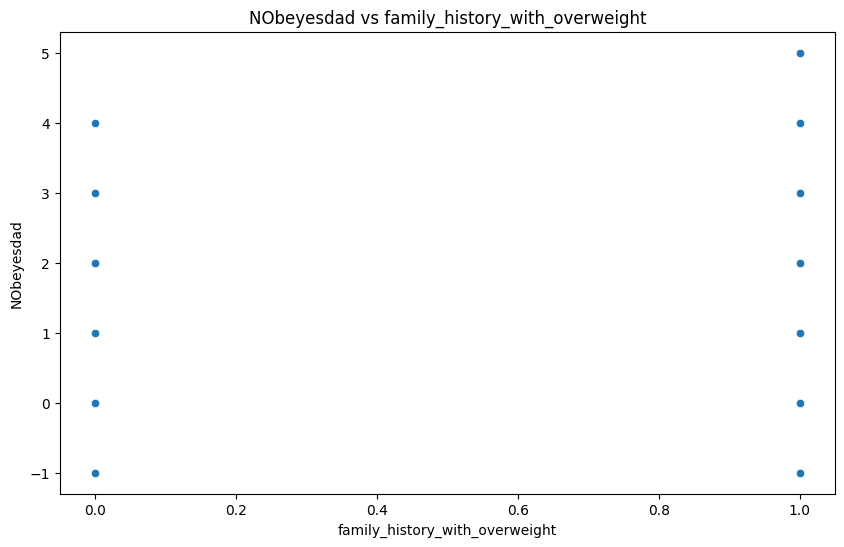

In [29]:
plot_data('family_history_with_overweight', 'NObeyesdad', data_clean)

In [30]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_clean)

Start by evaluating on all the features

In [31]:
# Context manager to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

In [32]:
num_features

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

Scale numerical data

In [33]:
scaler = StandardScaler()
data_scaled = data_clean.copy()
data_scaled[num_features] = scaler.fit_transform(data_scaled[num_features], data_scaled['NObeyesdad'])
data_scaled.head()

,Age,Height,Weight,FCVC,NCP,CAEC,CH2O,FAF,TUE,CALC,NObeyesdad,Gender_Male,family_history_with_overweight,FAVC,SMOKE,SCC,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,-0.523072,-0.875169,-0.861124,-0.197269,0.404376,1,-0.025408,-1.188443,0.561682,0,0.0,0,1,0,0,0,0,0,1,0
1,-0.523072,-1.946769,-1.166083,0.222745,0.404376,1,0.800090,2.338855,-1.080738,1,0.0,0,1,0,1,1,0,0,1,0
2,-0.207834,1.053709,-0.365567,-0.197269,0.404376,1,-0.025408,1.163089,0.561682,2,0.0,1,1,0,0,0,0,0,1,0
3,0.422641,1.053709,0.015632,0.222745,0.404376,1,-0.025408,1.163089,-1.080738,2,1.0,1,0,0,0,0,0,0,0,1
4,-0.365453,0.839390,0.122367,-0.197269,-2.165781,1,-0.025408,-1.188443,-1.080738,1,2.0,1,0,0,0,0,0,0,1,0


# Supervised Learning Methods

## Best Models, Overview

In [34]:
X = data_scaled.drop(columns='NObeyesdad')
y = data_scaled['NObeyesdad'] # response is obesity level

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'Neural Network': MLPClassifier()
}

# Evaluate models using cross-validation (5 folds)
for name, model in models.items():
    with suppress_stdout_stderr(), warnings.catch_warnings():
        warnings.simplefilter('ignore')
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'{name} CV Accuracy: {cv_scores.mean()}')

Logistic Regression CV Accuracy: 0.8710506467336853
KNN CV Accuracy: 0.849707872251804
LDA CV Accuracy: 0.876269545541534
SVM CV Accuracy: 0.9156263016289359
Decision Tree CV Accuracy: 0.9279395706453828
Random Forest CV Accuracy: 0.9341164683500128
Gradient Boosting CV Accuracy: 0.938851301910369
Naive Bayes CV Accuracy: 0.535797187918632
Neural Network CV Accuracy: 0.9255811597302743


Now going back to a simpler approach

## Logistic Regression

In [26]:
# Function to suppress stdout and stderr
@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def best_subset_selection(X, y):
    n = len(X.columns)
    results = []
    total_combinations = sum([len(list(itertools.combinations(X.columns, k))) for k in range(1, n + 1)])

    # Suppress specific warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

    with tqdm(total=total_combinations) as pbar:
        for k in range(1, n + 1):
            for combo in itertools.combinations(X.columns, k):
                try:
                    X_train_subset = sm.add_constant(X[list(combo)])
                    with suppress_stdout_stderr(), np.errstate(all='ignore'):
                        model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                    aic = model.aic
                    results.append((aic, combo))
                except (np.linalg.LinAlgError, ValueError):
                    pass
                pbar.update(1)
    
    best_model = sorted(results, key=lambda x: x[0])[0]
    return best_model[1]

In [55]:
# Find the best subset of features
best_features = best_subset_selection(X, y)
print('Best subset of features:', best_features)

  0%|          | 1232/524287 [00:42<4:57:42, 29.28it/s]


KeyboardInterrupt: 

In [36]:
def hybrid_feature_selection(X, y, initial_features=[]):
    included = list(initial_features)
    best_score = float('inf')
    while True:
        changed = False
        
        # Forward step
        excluded = list(set(X.columns) - set(included))
        for new_feature in excluded:
            try_features = included + [new_feature]
            X_train_subset = sm.add_constant(X[try_features])
            try:
                with suppress_stdout_stderr(), warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                score = model.aic
                if score < best_score:
                    best_score = score
                    best_feature = new_feature
                    changed = True
            except (np.linalg.LinAlgError, ValueError):
                continue
        if changed:
            included.append(best_feature)
            print(f'Forward step: {included} (AIC: {best_score})')
        
        worst_feature = ''
        # Backward step
        for feature in included:
            try_features = list(set(included) - {feature})
            if not try_features:
                continue
            X_train_subset = sm.add_constant(X[try_features])
            try:
                with suppress_stdout_stderr(), warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    model = sm.MNLogit(y, X_train_subset).fit(disp=0)
                score = model.aic
                if score < best_score:
                    best_score = score
                    worst_feature = feature
                    changed = True
            except (np.linalg.LinAlgError, ValueError):
                continue
        if changed and len(worst_feature) > 0:
            included.remove(worst_feature)
            print(f'Backward step: {included} (AIC: {best_score})')
        
        if not changed:
            break

    return included

In [37]:
# Use the hybrid feature selection to find the best subset of features
hybrid_features = hybrid_feature_selection(X, y)
print('Best subset of features:', hybrid_features)

Forward step: ['Weight'] (AIC: 4240.91748704769)
Forward step: ['Weight', 'FCVC'] (AIC: 3819.1931846346033)
Forward step: ['Weight', 'FCVC', 'Age'] (AIC: 3609.1301194855555)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP'] (AIC: 3393.9895316683205)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF'] (AIC: 3169.6475907023387)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC'] (AIC: 3004.966821669967)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O'] (AIC: 2881.0796043541177)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC'] (AIC: 2782.3387923247064)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC'] (AIC: 2690.532744543125)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation'] (AIC: 2606.0540758674415)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_histo

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE'] (AIC: 2542.271640927891)


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking'] (AIC: 2530.3934838400364)
Forward step: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking', 'SCC'] (AIC: 2495.484384576628)


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


Best subset of features: ['Weight', 'FCVC', 'Age', 'NCP', 'FAF', 'CALC', 'CH2O', 'FAVC', 'CAEC', 'MTRANS_Public_Transportation', 'family_history_with_overweight', 'TUE', 'MTRANS_Walking', 'SCC']


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\discrete\discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)


In [35]:
def fit_and_evaluate(model, X, y, report=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if report:
        print(classification_report(y_test, y_pred))
        
    print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')

    cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f'CV Accuracy: {cv_score.mean()}')
    return model

Seems as though we're failing to get the optimal set of features, as the full model still out-performs the one fit on the 'best' subset.

In [42]:
log_reg = LogisticRegression(random_state=42)
log_reg_fit = fit_and_evaluate(log_reg, X[hybrid_features], y)

              precision    recall  f1-score   support

        -1.0       0.75      0.89      0.82        55
         0.0       0.67      0.57      0.61        60
         1.0       0.63      0.67      0.65        55
         2.0       0.57      0.48      0.52        58
         3.0       0.66      0.64      0.65        64
         4.0       0.91      0.91      0.91        55
         5.0       0.93      1.00      0.96        75

    accuracy                           0.74       422
   macro avg       0.73      0.74      0.73       422
weighted avg       0.74      0.74      0.74       422

Test Accuracy: 0.7440758293838863
CV Accuracy: 0.7349596424671566


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

## Decision Trees

Single Tree, Grid Search

In [24]:
dt = DecisionTreeClassifier(random_state=42, max_features=X.shape[1])

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print(f'Best parameters found: {grid_search.best_params_}')
print(f'Best cross-validation accuracy: {grid_search.best_score_}')

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
12960 fits failed out of a total of 51840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3632 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn

Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation accuracy: 0.9284213844266078


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1051: UserWarning: One or more of the test scores are non-finite: [0.92651664 0.87437719 0.92604496 ... 0.29634812 0.32006844 0.29634812]
  warnings.warn(


In [43]:
dt_best = fit_and_evaluate(grid_search.best_estimator_, X, y)

              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98        55
         0.0       0.95      0.97      0.96        60
         1.0       0.93      0.95      0.94        55
         2.0       0.98      0.95      0.96        58
         3.0       0.98      1.00      0.99        64
         4.0       1.00      1.00      1.00        55
         5.0       1.00      0.99      0.99        75

    accuracy                           0.98       422
   macro avg       0.98      0.98      0.98       422
weighted avg       0.98      0.98      0.98       422

Test Accuracy: 0.976303317535545
CV Accuracy: 0.9284213844266078


Random Forest

In [44]:
rf = RandomForestClassifier(random_state=42, n_estimators=100, max_features=X.shape[1])
rf = fit_and_evaluate(rf, X, y)

              precision    recall  f1-score   support

        -1.0       0.87      1.00      0.93        55
         0.0       0.93      0.85      0.89        60
         1.0       0.96      0.93      0.94        55
         2.0       0.98      0.98      0.98        58
         3.0       0.98      0.97      0.98        64
         4.0       0.98      1.00      0.99        55
         5.0       1.00      0.99      0.99        75

    accuracy                           0.96       422
   macro avg       0.96      0.96      0.96       422
weighted avg       0.96      0.96      0.96       422

Test Accuracy: 0.9597156398104265
CV Accuracy: 0.9435940156026612


Boosting

In [45]:
gb = GradientBoostingClassifier(random_state=42, n_estimators=100, max_features=X.shape[1])
gb = fit_and_evaluate(gb, X, y)

              precision    recall  f1-score   support

        -1.0       0.92      1.00      0.96        55
         0.0       0.93      0.88      0.91        60
         1.0       0.94      0.91      0.93        55
         2.0       0.97      0.97      0.97        58
         3.0       0.98      0.94      0.96        64
         4.0       0.93      1.00      0.96        55
         5.0       1.00      0.99      0.99        75

    accuracy                           0.95       422
   macro avg       0.95      0.95      0.95       422
weighted avg       0.96      0.95      0.95       422

Test Accuracy: 0.9549763033175356
CV Accuracy: 0.9393252355596582


## Neural Network

In [36]:
mlp = MLPClassifier(random_state=42)
mlp = fit_and_evaluate(mlp, X, y, report=False)

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.9265402843601895


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

CV Accuracy: 0.9260539676464296


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
learning_modes = ['constant', 'invscaling', 'adaptive']
solvers = ['lbfgs', 'sgd', 'adam']
activations = ['identity', 'logistic', 'tanh', 'relu']
best_models = []
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
for learning_mode in learning_modes:
    for solver in solvers:
        for activation in activations:
            mlp = MLPClassifier(random_state=42, learning_rate=learning_mode, solver=solver, activation=activation)
            mlp.fit(X_train, y_train)
            if mlp.score(X_test, y_test) > 0.95:
                print(f'Learning mode: {learning_mode}, Solver: {solver}, Activation: {activation}')
                print(f'Test Accuracy: {mlp.score(X_test, y_test)}')
                best_models.append(mlp)

c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Learning mode: constant, Solver: lbfgs, Activation: identity
Test Accuracy: 0.9620853080568721
Learning mode: constant, Solver: lbfgs, Activation: tanh
Test Accuracy: 0.9549763033175356


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Learning mode: invscaling, Solver: lbfgs, Activation: identity
Test Accuracy: 0.9620853080568721
Learning mode: invscaling, Solver: lbfgs, Activation: tanh
Test Accuracy: 0.9549763033175356


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

Learning mode: adaptive, Solver: lbfgs, Activation: identity
Test Accuracy: 0.9620853080568721
Learning mode: adaptive, Solver: lbfgs, Activation: tanh
Test Accuracy: 0.9549763033175356


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

6 out of 36 tested models exceeded 95% accuracy

In [40]:
len(best_models)

6

Learning mode seems to not be significant in this case, but clearly the lbfgs solver and identity activation function are the optimal pick here

In [48]:
for model in best_models:
    print('Activation:', model.activation)
    print('Learning rate:', model.learning_rate)
    print('Solver:', model.solver)
    print('Score:', model.score(X_test, y_test))

Activation: identity
Learning rate: constant
Solver: lbfgs
Score: 0.9620853080568721
Activation: tanh
Learning rate: constant
Solver: lbfgs
Score: 0.9549763033175356
Activation: identity
Learning rate: invscaling
Solver: lbfgs
Score: 0.9620853080568721
Activation: tanh
Learning rate: invscaling
Solver: lbfgs
Score: 0.9549763033175356
Activation: identity
Learning rate: adaptive
Solver: lbfgs
Score: 0.9620853080568721
Activation: tanh
Learning rate: adaptive
Solver: lbfgs
Score: 0.9549763033175356


c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\rgbmr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptr

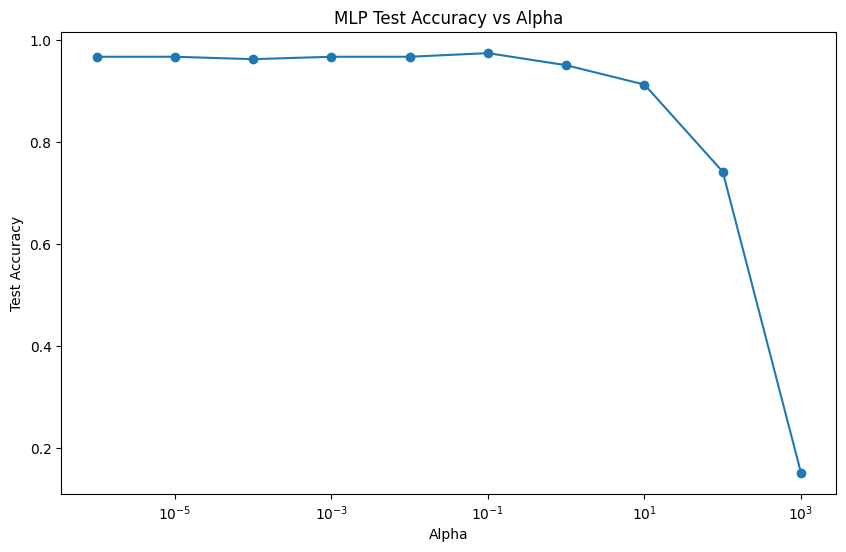

In [49]:
alphas = np.logspace(-6, 3, 10)
scores = []
for alpha in alphas:
    mlp = MLPClassifier(random_state=42, solver='lbfgs', activation='identity', alpha=alpha)
    mlp.fit(X_train, y_train)
    scores.append(mlp.score(X_test, y_test))

# plot the alpha values against the scores
plt.figure(figsize=(10, 6))
plt.plot(alphas, scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Test Accuracy')
plt.title('MLP Test Accuracy vs Alpha')
plt.show()

In [ ]:
scores = []
for n_hidden in range(10, 1001, 10):
    mlp = MLPClassifier(random_state=42, solver='lbfgs', activation='identity', alpha=0.01, hidden_layer_sizes=(n_hidden,))
    mlp.fit(X_train, y_train)
    scores.append(mlp.score(X_test, y_test))

Seems that, on average, that a hidden layer size of 200 or less results in the best model

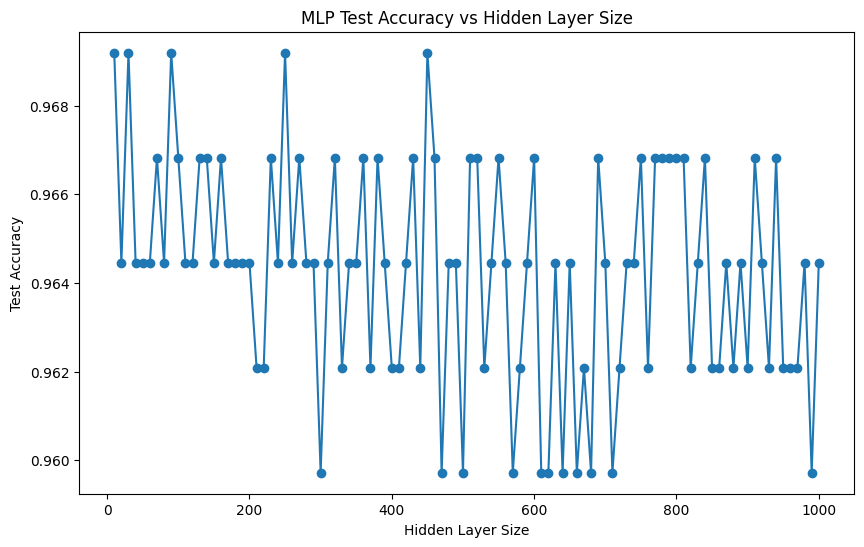

In [52]:
# plot the hidden layer sizes against the scores
plt.figure(figsize=(10, 6))
plt.plot(range(10, 1001, 10), scores, marker='o')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Test Accuracy')
plt.title('MLP Test Accuracy vs Hidden Layer Size')
plt.show()

## SVM

# Unsupervised Learning Methods